In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
# detection the change
def trigger_detection(data, threshold, start=0, end=-1):
    flag = False
    intervals = []
    if end < start:
        end = data.shape[0]

    for i in np.arange(start, end):
        if (data[i] < threshold):
            if flag == False:
                flag = True
                s = i
            else:
                if data[i+1] > threshold:
                    e = i
                    intervals.append((s, e))
                    flag = False

    return np.array(intervals)[:, 0]

In [3]:
# paths were the raw data is
root_path = 'data/'
data_path = os.path.join(root_path, 'Experiment')
shimmer_path = os.path.join(data_path, 'shimmer')
arduino_path = os.path.join(data_path, 'groove-GSR')

# list all files (ignoring the hidden macos file)
shimmer_files = [x for x in os.listdir(shimmer_path) if x.endswith('.csv')]
gsr_files = [x for x in os.listdir(arduino_path) if x.endswith('.csv')]

In [4]:
shimmer_files

['04_EDA_SS2023_Exp1_Session1_Shimmer_D210_Calibrated_SD.csv',
 '02_EMG_SS2023_Exp1_Session1_Shimmer_F16C_Calibrated_SD.csv',
 '04_EMG_SS2023_Exp1_Session1_Shimmer_EC93_Calibrated_SD.csv',
 'Trigger_SS2023_Exp1_Session1_Shimmer_895A_Calibrated_SD.csv',
 '03_EDA_SS2023_Exp1_Session1_Shimmer_86D4_Calibrated_SD.csv',
 '03_EMG_SS2023_Exp1_Session1_Shimmer_EC8E_Calibrated_SD.csv',
 '01_EMG_SS2023_Exp1_Session1_Shimmer_F0BA_Calibrated_SD.csv']

In [5]:
# paths
eda_indexes = [0, 4]
trigger_index = 3

trigger_path = shimmer_files[trigger_index]
eda_path = [x for i,x in enumerate(shimmer_files) if i in eda_indexes]
emg_path = [x for i,x in enumerate(shimmer_files) if i not in eda_indexes and i != trigger_index] 

# paths were the preprocessed data should be
out_path = os.path.join(root_path, 'Segmented')
emg_out_path = os.path.join(out_path, 'EMG')
eda_out_path = os.path.join(out_path, 'EDA')

# check if the output folders exist and create them if necessary
for folder in [out_path, emg_out_path, eda_out_path]:
    if not os.path.exists(folder):
        os.mkdir(folder)

In [6]:
# trigger loading and detection
df = pd.read_csv(os.path.join(shimmer_path, trigger_path), skiprows=[0,2])
columns = df.columns

timestamps = np.array(df[columns[0]])
trigger_values = np.array(df[columns[1]])

trigger_pos = trigger_detection(trigger_values, 500)
trigger_timestamps = timestamps[trigger_pos]

In [7]:
# 66 triggers:
#     1 -> experiment start
#     2-65 -> the begin and the end of 32 videos
#     66 -> calibration start
len(trigger_pos)

66

In [8]:
emg_path[0]

'02_EMG_SS2023_Exp1_Session1_Shimmer_F16C_Calibrated_SD.csv'

In [9]:
# segmenting the EMG data
for emg in emg_path:
    file_name = os.path.join(shimmer_path, emg)
    out_path = os.path.join(emg_out_path, emg)
    
    df = pd.read_csv(file_name, skiprows=[0, 2])
    columns = df.columns
    
    timestamps = np.array(df[columns[0]])
    emg_ch1 = np.array(df[columns[2]])
    emg_ch2 = np.array(df[columns[3]])
    
    out_timestamps = []
    out_ch1 = []
    out_ch2 = []
    out_labels = []
    
    start_flag = False
    for i, time in enumerate(trigger_timestamps[1:-1]): 
        if not start_flag:
            start_pos = np.argwhere(timestamps >= time)[0, 0]
            end_pos = np.argwhere(timestamps >= trigger_timestamps[i+2])[0, 0]

            for pos in range(start_pos, end_pos+1):
                out_timestamps.append(timestamps[pos])
                out_ch1.append(emg_ch1[pos])
                out_ch2.append(emg_ch2[pos])
                out_labels.append(int(i / 2 + 1))
            start_flag = True
        else:
            start_flag = False
            
    df = pd.DataFrame({columns[0]: out_timestamps, columns[2]: out_ch1, columns[3]: out_ch2, 'trial': out_labels})
    df.to_csv(out_path)

In [10]:
# segmenting the EDA data
for eda in eda_path:
    file_name = os.path.join(shimmer_path, eda)
    out_path = os.path.join(eda_out_path, eda)
    
    df = pd.read_csv(file_name, skiprows=[0, 2])
    columns = df.columns

    timestamps = np.array(df[columns[0]])
    skin_conductance = np.array(df[columns[2]])
#     ppg_to_hr = np.array(df[columns[6]])
    
    out_timestamps = []
    out_skin_conductance = []
#     out_ppg_to_hr = []
    out_labels = []
    
    start_flag = False
    for i, time in enumerate(trigger_timestamps[1:-1]):
        if not start_flag:
            start_pos = np.argwhere(timestamps >= time)[0, 0]
            end_pos = np.argwhere(timestamps >= trigger_timestamps[i+2])[0, 0]
            for pos in range(start_pos, end_pos+1):
                out_timestamps.append(timestamps[pos])
                out_skin_conductance.append(skin_conductance[pos])
        #             out_ppg_to_hr.append(ppg_to_hr[pos])
                out_labels.append(int(i / 2 + 1))

            start_flag = True
        else:
            start_flag = False
            
    df = pd.DataFrame({columns[0]: out_timestamps, columns[2]: out_skin_conductance,
                       'trial': out_labels})
    df.to_csv(out_path)

In [11]:
gsr_files

['A0-01_A1-02_COM19_20230227_143419_clean.csv']

In [12]:
file_name = os.path.join(arduino_path, gsr_files[0])
out_path_A0 = os.path.join(eda_out_path, '01-A0_COM19_20230227_143419.csv')
out_path_A1 = os.path.join(eda_out_path, '02-A1_COM19_20230227_143419.csv')

df = pd.read_csv(file_name)
columns = df.columns

In [13]:
# contains 67 triggers, the first trigger is generated by opening the serial port
arduino_trigger_pos = trigger_detection(df['trigger_value'], 0.5)

In [14]:
# need to divide 1e3 when calculating the period
arduino_relative_start = df['relative_time'][arduino_trigger_pos[1]]
shimmer_start_timestamp = trigger_timestamps[0]

In [15]:
GSR_A0 = np.array(df[columns[3]])
GSR_A1 = np.array(df[columns[4]])
relative_time = np.array(df[columns[5]])
timestamps = (relative_time - arduino_relative_start) / 1e3 + shimmer_start_timestamp

out_timestamps = []
out_GSR_A0 = []
out_GSR_A1 = []
out_labels = []

start_flag = False
for i, time in enumerate(trigger_timestamps[1:-1]):
    if not start_flag:
        start_pos = np.argwhere(timestamps >= time)[0, 0]
        end_pos = np.argwhere(timestamps >= trigger_timestamps[i+2])[0, 0]
        for pos in range(start_pos, end_pos+1):
            out_timestamps.append(timestamps[pos])
            out_GSR_A0.append(GSR_A0[pos])
            out_GSR_A1.append(GSR_A1[pos])
            out_labels.append(int(i / 2 + 1))

        start_flag = True
    else:
        start_flag = False

df_A0 = pd.DataFrame({'timestamp_UNIX': out_timestamps, 'GSR': out_GSR_A0, 'trial': out_labels})
df_A1 = pd.DataFrame({'timestamp_UNIX': out_timestamps, 'GSR': out_GSR_A1, 'trial': out_labels})

df_A0.to_csv(out_path_A0, sep=',')
df_A1.to_csv(out_path_A1, sep=',')

### Fourier

In [18]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.fft import rfft, irfft, rfftfreq

Text(0.5, 0, 'Frequency (Hz)')

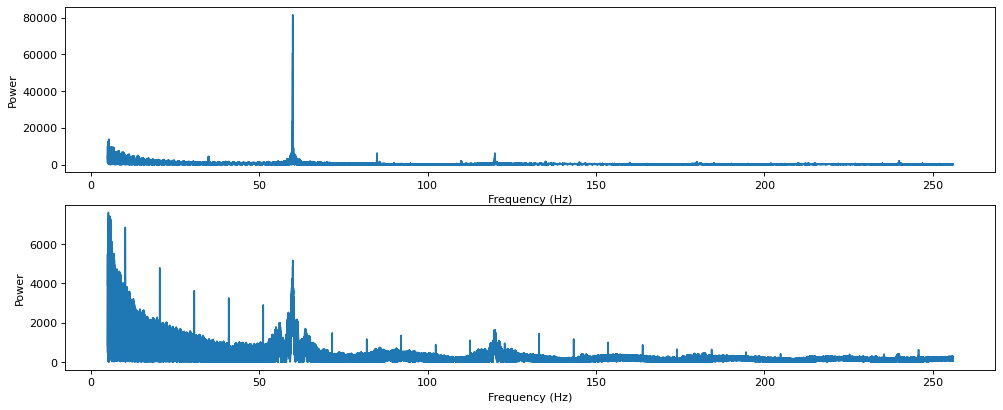

In [19]:
# segmenting the EMG data

file_name = os.path.join(shimmer_path, emg_path[0])

df = pd.read_csv(file_name, skiprows=[0, 2])
columns = df.columns

timestamps = np.array(df[columns[0]])
emg_ch1 = np.array(df[columns[2]])
emg_ch2 = np.array(df[columns[3]])

from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=80)

# Number of samples in normalized_tone
N_ch1 = emg_ch1.shape[0]
N_ch2 = emg_ch2.shape[0]
sample_rate = 512

yf_ch1 = rfft(emg_ch1)
xf_ch1 = rfftfreq(N_ch1, 1 / sample_rate)

yf_ch2 = rfft(emg_ch2)
xf_ch2 = rfftfreq(N_ch2, 1 / sample_rate)

start_freq = 5
start_pos_ch1 = np.argwhere(xf_ch1 > start_freq)[0, 0]
start_pos_ch2 = np.argwhere(xf_ch2 > start_freq)[0, 0]
plt.subplot(2, 1, 1)
plt.plot(xf_ch1[start_pos_ch1:], np.abs(yf_ch1[start_pos_ch1:]))
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')

plt.subplot(2, 1, 2)
plt.plot(xf_ch2[start_pos_ch2:], np.abs(yf_ch2[start_pos_ch2:]))
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')